In [ ]:
#this code is referenced from the official tutorial

# Object Detection

In this tutorial, you will learn:
- to perform inference with a MMDetection detector.
- to train a new detector with a new dataset.

In [1]:
cd mmdetection

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection


/home/z890/.conda/envs/mmr/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import MMDetection

In [2]:
from mmengine.utils import get_git_hash
from mmengine.utils.dl_utils import collect_env as collect_base_env

import mmdet
def collect_env():
    """Collect the information of the running environments."""
    env_info = collect_base_env()
    env_info['MMDetection'] = f'{mmdet.__version__}+{get_git_hash()[:7]}'
    return env_info


if __name__ == '__main__':
    for name, val in collect_env().items():
        print(f'{name}: {val}')

sys.platform: linux
Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
CUDA available: True
MUSA available: False
numpy_random_seed: 2147483648
GPU 0: NVIDIA GeForce RTX 5090
CUDA_HOME: /usr/local/cuda-12.8
NVCC: Cuda compilation tools, release 12.8, V12.8.93
GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
PyTorch: 2.7.0+cu128
PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90;-gencode;arch=compute_100,code=sm_100;-genco

In [3]:
# We download the pre-trained checkpoints for inference and finetuning.
!mkdir ./checkpoint
!mkdir ./output

In [4]:
# there are plenty of models
# you may check what models are available on
# https://mmdetection.readthedocs.io/en/latest/modelzoo_statistics.html

In [4]:
!mim download mmdet --config rtmdet_tiny_8xb32-300e_coco --dest ./checkpoint

processing rtmdet_tiny_8xb32-300e_coco...
downloading ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 MiB 63.3 MB/s eta 0:00:0031m60.3 MB/s eta 0:00:01
Successfully downloaded rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth to /home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/checkpoint
Successfully dumped rtmdet_tiny_8xb32-300e_coco.py to /home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/checkpoint


The above code downloads weights of a pretrained model <br>
if it was not successful <br>
go to terminal, and run: <br>
conda activate "your environment name" <br>
cd mmdetection <br>
mim download mmdet --config rtmdet_tiny_8xb32-300e_coco --dest ./checkpoint

### Inference the detector

Since the model is successfully created and loaded, let's see how good it is. We use the high-level API `DetInferencer` implemented in the MMDetection. This API is created to ease the inference process. The details of the codes can be found [here](https://github.com/open-mmlab/mmdetection/blob/dev-3.x/mmdet/apis/det_inferencer.py).

In [5]:
# load the pre-trained model
from mmdet.apis import init_detector
from mmengine import Config

# Load config file for the model
config_file = './configs/rtmdet/rtmdet_tiny_8xb32-300e_coco.py' # Example config path
config = Config.fromfile(config_file)

# Initialize detector with pre-trained weights, we just downloaded
checkpoint_file = './checkpoint/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth'  # Pre-trained weights
model = init_detector(config, checkpoint_file, device='cuda')

# Access model metadata
print(model.dataset_meta)

Loads checkpoint by local backend from path: ./checkpoint/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std

{'classes': ('person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwa

In [6]:
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

# URL of the image
url = "https://as1.ftcdn.net/jpg/02/36/99/22/1000_F_236992283_sNOxCVQeFLd5pdqaKGh8DRGMZy7P4XKm.jpg"  # Direct URL to the image

# Fetch the image content
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img.save('Cat.jpg')


/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/.conda/envs/mmr/lib/python3.10/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


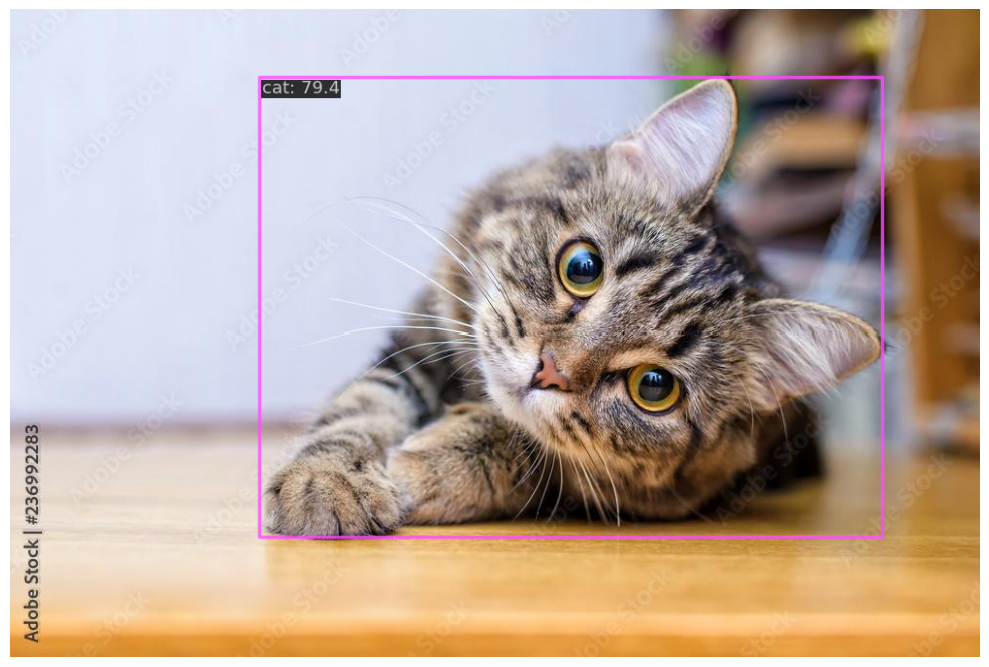

Detection Results:
Class: cat, Score: 0.7944, BBox: [256.9560546875, 71.4450912475586, 897.800537109375, 544.156494140625]


In [7]:
# from the output of last line, we know the model can detect cat
# use the model to spot a cat
from mmdet.apis import inference_detector
import mmcv
import matplotlib.pyplot as plt
import numpy as np

# Run inference on a cat image, or any image you want
img_path = 'Cat.jpg'
result = inference_detector(model, img_path)

# Visualize the results
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

# Get class names from metadata
class_names = model.dataset_meta.get('classes', None)
threshold = 0.5

# Visualize detection results
from mmdet.visualization import DetLocalVisualizer
visualizer = DetLocalVisualizer()
visualizer.dataset_meta = model.dataset_meta
visualizer.add_datasample(
    'result',
    img,
    data_sample=result,
    draw_gt=False,
    wait_time=0,
    show=True,
    pred_score_thr=threshold  # Score threshold for detections
)

# Alternative visualization approach
plt.figure(figsize=(10, 10))
plt.imshow(visualizer.get_image())
plt.axis('off')
plt.tight_layout()
plt.show()

# Print the prediction results
print("Detection Results:")
for label_id, score, bbox in zip(
    result.pred_instances.labels, 
    result.pred_instances.scores, 
    result.pred_instances.bboxes
):
    if score>threshold:
        class_name = class_names[label_id]
        print(f"Class: {class_name}, Score: {score:.4f}, BBox: {bbox.tolist()}")

In [8]:
# Show the structure of result dict
from rich.pretty import pprint
pprint(result, max_length=4)

<DetDataSample(
│   
│   META INFORMATION
│   batch_input_shape: (640, 640)
│   img_id: 0
│   img_path: 'Cat.jpg'
│   pad_shape: (640, 640)
│   scale_factor: (0.64, 0.6407185628742516)
│   ori_shape: (668, 1000)
│   img_shape: (640, 640)
│   
│   DATA FIELDS
│   ignored_instances: <InstanceData(
│   │   │   
│   │   │   META INFORMATION
│   │   │   
│   │   │   DATA FIELDS
│   │   │   bboxes: tensor([], device='cuda:0', size=(0, 4))
│   │   │   labels: tensor([], device='cuda:0', dtype=torch.int64)
│   │   ) at 0x7486e3ff7400>
│   gt_instances: <InstanceData(
│   │   │   
│   │   │   META INFORMATION
│   │   │   
│   │   │   DATA FIELDS
│   │   │   bboxes: tensor([], device='cuda:0', size=(0, 4))
│   │   │   labels: tensor([], device='cuda:0', dtype=torch.int64)
│   │   ) at 0x7486e3ff73d0>
│   pred_instances: <InstanceData(
│   │   │   
│   │   │   META INFORMATION
│   │   │   
│   │   │   DATA FIELDS
│   │   │   bboxes: tensor([[256.9561,  71.4451, 897.8005, 544.1565],
│   │   │   │   │   │   [  9.0331, 415.3661, 996.5524, 660.5244],
│   │   │   │   │   │   [  4.6649,  32.7234, 943.3233, 668.6279],
│   │   │   │   │   │   ...,
│   │   │   │   │   │   [413.7454,   0.0000, 973.1366, 493.6835],
│   │   │   │   │   │   [579.3619, 349.4852, 725.9158, 485.1869],
│   │   │   │   │   │   [249.6865,  71.9381, 897.8201, 546.4193]], device='cuda:0')
│   │   │   labels: tensor([15,  2, 13,  2, 13, 56, 41, 56, 58, 13, 58, 60, 56, 15, 56, 56, 60,  1,
│   │   │   │   │   │    2, 57, 58, 13,  2, 63, 56, 22, 58, 56,  1, 75, 41, 58, 56,  1, 62, 71,
│   │   │   │   │   │    1, 60, 59, 60,  0, 60,  0, 41,  2,  2,  2, 39, 73, 28, 60, 13, 71,  0,
│   │   │   │   │   │    7, 40, 13, 16, 72, 13, 57, 56, 57,  0, 13, 56, 60, 45, 57, 56, 25,  0,
│   │   │   │   │   │    7, 40, 60, 13,  0, 39, 60, 41, 60, 56,  0, 41,  7,  0, 41,  0, 56, 25,
│   │   │   │   │   │    3, 59, 56,  2,  2, 69,  2, 13, 69, 62,  0,  0, 72,  0, 39,  3,  3, 50,
│   │   │   │   │   │   75, 40, 13, 21, 60, 57, 41, 63,  7,  5,  0,  0, 40,  0,  0,  0, 56, 27,
│   │   │   │   │   │    3, 59,  3, 39, 28, 13, 58, 56, 42, 56, 56, 63,  0, 40, 69, 58, 39, 56,
│   │   │   │   │   │   44,  7, 75, 59, 56, 41, 13, 45, 41,  2, 26, 58, 58, 34, 13, 58, 62, 56,
│   │   │   │   │   │   41,  1, 61,  8, 56, 13, 25,  2, 56, 56, 41, 69,  2, 13, 28,  7,  6,  9,
│   │   │   │   │   │   58, 62,  7,  2, 41, 14, 58, 59, 68, 56, 58,  1, 41, 56, 41, 25,  0,  0,
│   │   │   │   │   │   42, 26,  0,  1, 61, 15, 39, 17, 25, 43, 62, 26, 41,  0,  2, 56, 39, 62,
│   │   │   │   │   │    4, 69, 41, 72, 71, 60, 28, 40,  2, 28, 15, 61, 56, 40, 66, 69, 43, 58,
│   │   │   │   │   │   56,  8, 58, 66,  2, 79, 39, 60,  2, 44, 56,  8,  0, 45,  8, 60,  0, 56,
│   │   │   │   │   │   39,  0, 13,  5, 39, 36, 63,  2, 26, 58,  9,  0,  0,  8, 41, 34, 39, 56,
│   │   │   │   │   │   45, 24, 56,  0,  0, 60,  0,  0, 72, 40, 39, 39, 73, 73, 56, 15, 41, 60,
│   │   │   │   │   │    0, 46, 39, 25,  0,  0,  2, 57, 15, 58, 46, 18], device='cuda:0')
│   │   │   scores: tensor([0.7944, 0.2058, 0.1607, 0.1460, 0.1453, 0.1429, 0.1386, 0.1275, 0.1184,
│   │   │   │   │   │   0.1099, 0.1088, 0.1033, 0.1004, 0.1001, 0.0964, 0.0954, 0.0940, 0.0918,
│   │   │   │   │   │   0.0887, 0.0853, 0.0842, 0.0821, 0.0816, 0.0814, 0.0805, 0.0792, 0.0780,
│   │   │   │   │   │   0.0771, 0.0770, 0.0755, 0.0754, 0.0751, 0.0745, 0.0739, 0.0738, 0.0699,
│   │   │   │   │   │   0.0688, 0.0665, 0.0655, 0.0655, 0.0648, 0.0644, 0.0642, 0.0627, 0.0624,
│   │   │   │   │   │   0.0623, 0.0620, 0.0617, 0.0612, 0.0608, 0.0601, 0.0600, 0.0597, 0.0590,
│   │   │   │   │   │   0.0587, 0.0586, 0.0581, 0.0579, 0.0572, 0.0571, 0.0557, 0.0549, 0.0541,
│   │   │   │   │   │   0.0539, 0.0535, 0.0529, 0.0523, 0.0523, 0.0521, 0.0519, 0.0517, 0.0515,
│   │   │   │   │   │   0.0515, 0.0509, 0.0504, 0.0500, 0.0498, 0.0490, 0.0489, 0.0485, 0.0483,
│   │   │   │   │   │   0.0481, 0.0480, 0.0477, 0.0476, 0.0470, 0.0468, 0.0467, 0.0466, 0.0464,
│   │   │   │   │   │   0.0456, 0.0456, 0.0

## Train with customized datasets

In this part, you will know how to train predefined models with customized datasets and then test it. We use the [balloon dataset](https://github.com/matterport/Mask_RCNN/tree/master/samples/balloon) as an example to describe the whole process.

The basic steps are as below:

1. Prepare the customized dataset
2. Prepare a config
3. Train, test, and infer models on the customized dataset.


### Prepare the customized dataset

There are three ways to support a new dataset in MMDetection:

1. Reorganize the dataset into COCO format.
2. Reorganize the dataset into a middle format.
3. Implement a new dataset.

Usually, we recommend using the first two methods which are usually easier than the third.

In this tutorial, we use the ballon dataset an example of converting the data into COCO format.

**Note**: Datasets and metrics have been decoupled except CityScapes since MMDetection 3.0. Therefore, users can use any kind of evaluation metrics for any format of datasets during validation. For example: evaluate on COCO dataset with VOC metric, or evaluate on OpenImages dataset with both VOC and COCO metrics.

In [9]:
# Download the data and unzip it
%run ./tools/misc/download_dataset.py --dataset-name balloon --save-dir data --unzip

100%|██████████████████████████████████████| 36.9M/36.9M [00:02<00:00, 16.0MB/s]


Unzipping balloon_dataset.zip


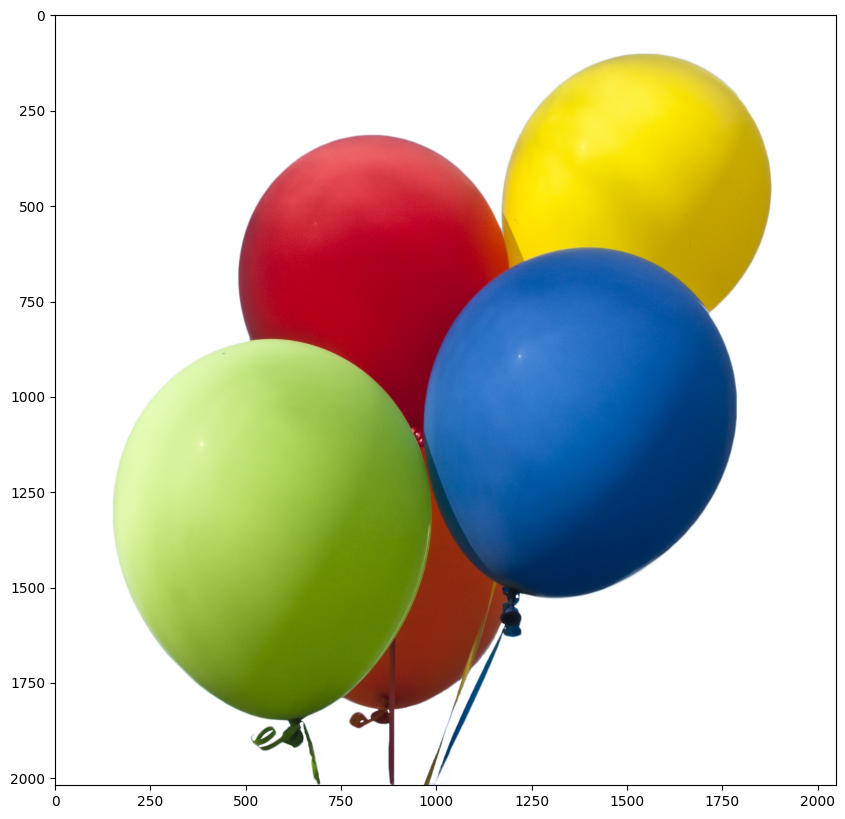

In [10]:
# Let's take a look at the dataset image
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('data/balloon/train/10464445726_6f1e3bbe6a_k.jpg')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

#### COCO annotation format
The necessary keys of COCO format for instance segmentation are as below, for the complete details, please refer [here](https://cocodataset.org/#format-data).
This case we only do detection, so "segmentation" can be set to None.

```json
{
    "images": [image],
    "annotations": [annotation],
    "categories": [category]
}
image = {
    "id": int,
    "width": int,
    "height": int,
    "file_name": str,
}
annotation = {
    "id": int,
    "image_id": int,
    "category_id": int,
    "segmentation": RLE or [polygon],
    "area": float,
    "bbox": [x,y,width,height], # (x, y) are the coordinates of the upper left corner of the bbox
    "iscrowd": 0 or 1,
}
categories = [{
    "id": int,
    "name": str,
    "supercategory": str,
}]
```

Assume we use the balloon dataset.
After downloading the data, we need to implement a function to convert the annotation format into the COCO format. Then we can use implemented `CocoDataset` to load the data and perform training and evaluation.

If you take a look at the dataset, you will find the dataset format is as below:

```json
{'base64_img_data': '',
 'file_attributes': {},
 'filename': '34020010494_e5cb88e1c4_k.jpg',
 'fileref': '',
 'regions': {'0': {'region_attributes': {},
   'shape_attributes': {'all_points_x': [1020,
     1000,
     994,
     1003,
     1023,
     1050,
     1089,
     1134,
     1190,
     1265,
     1321,
     1361,
     1403,
     1428,
     1442,
     1445,
     1441,
     1427,
     1400,
     1361,
     1316,
     1269,
     1228,
     1198,
     1207,
     1210,
     1190,
     1177,
     1172,
     1174,
     1170,
     1153,
     1127,
     1104,
     1061,
     1032,
     1020],
    'all_points_y': [963,
     899,
     841,
     787,
     738,
     700,
     663,
     638,
     621,
     619,
     643,
     672,
     720,
     765,
     800,
     860,
     896,
     942,
     990,
     1035,
     1079,
     1112,
     1129,
     1134,
     1144,
     1153,
     1166,
     1166,
     1150,
     1136,
     1129,
     1122,
     1112,
     1084,
     1037,
     989,
     963],
    'name': 'polygon'}}},
 'size': 1115004}
```

The annotation is a JSON file where each key indicates an image's all annotations.
The code to convert the balloon dataset into coco format is as below.

Using the function below, users can successfully convert the annotation file into json format, then we can use `CocoDataset` to train and evaluate the model with `CocoMetric`.

In [11]:
import os.path as osp
import mmcv
from mmengine.fileio import dump, load
from mmengine.utils import track_iter_progress

def convert_balloon_to_coco(ann_file, out_file, image_prefix):
    data_infos = load(ann_file)

    annotations = []
    images = []
    obj_count = 0
    data_infos = list(data_infos.values())
    for idx, v in enumerate(track_iter_progress(data_infos)):
        filename = v['filename']
        img_path = osp.join(image_prefix, filename)
        height, width = mmcv.imread(img_path).shape[:2]

        images.append(
            dict(id=idx, file_name=filename, height=height, width=width))

        for _, obj in v['regions'].items():
            assert not obj['region_attributes']
            obj = obj['shape_attributes']
            px = obj['all_points_x']
            py = obj['all_points_y']
            #poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)] # we dont need poly when doing detection
            #poly = [p for x in poly for p in x]

            x_min, y_min, x_max, y_max = (min(px), min(py), max(px), max(py))

            data_anno = dict(
                image_id=idx,
                id=obj_count,
                category_id=0,
                bbox=[x_min, y_min, x_max - x_min, y_max - y_min],
                area=(x_max - x_min) * (y_max - y_min),
                #segmentation=[poly],
                iscrowd=0)
            annotations.append(data_anno)
            obj_count += 1

    coco_format_json = dict(
        images=images,
        annotations=annotations,
        categories=[{
            'id': 0,
            'name': 'balloon'
        }])
    dump(coco_format_json, out_file)

convert_balloon_to_coco(ann_file='data/balloon/train/via_region_data.json',
                        out_file='data/balloon/train.json',
                        image_prefix='data/balloon/train')
convert_balloon_to_coco(ann_file='data/balloon/val/via_region_data.json',
                        out_file='data/balloon/val.json',
                        image_prefix='data/balloon/val')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 61/61, 150.8 task/s, elapsed: 0s, ETA:     0s
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 13/13, 141.4 task/s, elapsed: 0s, ETA:     0s


## Prepare a config

The second step is to prepare a config thus the dataset could be successfully loaded. Assume that we want to use RTMDet-tiny, the config to train the detector on balloon dataset is as below. Assume the config is under directory `configs/rtmdet/` and named as `rtmdet_tiny_1xb4-20e_balloon.py`, the config is as below.


In [12]:
# set configs for our model
# please revise the details inside for your task, take attention to #
# if you have no idea how to revise, just set %run tools/train.py configs/rtmdet/rtmdet_tiny_1xb4-20e.py first
# it will generate the used configs in work_dirs/
# then, you can copy the part that need to be revised and edit on it
# for more augmentation, you can refer to
# https://mmdetection.readthedocs.io/en/v2.19.1/tutorials/data_pipeline.html
# https://mmdetection.readthedocs.io/en/v2.16.0/_modules/mmdet/datasets/pipelines/transforms.html
# for mixup and mosaic
# https://mmdetection.readthedocs.io/en/latest/advanced_guides/how_to.html#use-mosaic-augmentation

config_balloon = """
# set model name
_base_ = './rtmdet_tiny_8xb32-300e_coco.py'

# dataset location
data_root = 'data/balloon/'

# Training parameters, set according to you device capacity
train_batch_size_per_gpu = 4
train_num_workers = 2

max_epochs = 20
stage2_num_epochs = 1
base_lr = 0.00008

metainfo = {
    'classes': ('balloon', ), # names of classes
    'palette': [              # any color you want
        (220, 20, 60),
    ]
}

# customed augmentation
train_pipeline=[
    dict(backend_args=None, type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_label=True),
    dict(
        img_scale=(
            640,
            640,
        ),
        max_cached_images=20,
        pad_val=114.0,
        random_pop=False,
        type='CachedMosaic'),
    dict(
        keep_ratio=True,
        ratio_range=(
            0.5,
            2.0,
        ),
        scale=(
            1280,
            1280,
        ),
        type='RandomResize'),
    dict(crop_size=(
        640,
        640,
    ), type='RandomCrop'),
    dict(type='YOLOXHSVRandomAug'),
    dict(prob=0.5, type='RandomFlip'),
    dict(
        pad_val=dict(img=(
            114,
            114,
            114,
        )),
        size=(
            640,
            640,
        ),
        type='Pad'),
    dict(
        img_scale=(
            640,
            640,
        ),
        max_cached_images=10,
        pad_val=(
            114,
            114,
            114,
        ),
        prob=0.5,
        random_pop=False,
        ratio_range=(
            1.0,
            1.0,
        ),
        type='CachedMixUp'),
    dict(type='PackDetInputs'),
]

train_dataloader = dict(
    batch_size=train_batch_size_per_gpu,
    num_workers=train_num_workers,
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='train/'),
        ann_file='train.json',
        pipeline=train_pipeline))

val_dataloader = dict(
    dataset=dict(
        data_root=data_root,
        metainfo=metainfo,
        data_prefix=dict(img='val/'),
        ann_file='val.json'))

test_dataloader = val_dataloader

val_evaluator = dict(ann_file=data_root + 'val.json')

test_evaluator = val_evaluator

model = dict(bbox_head=dict(num_classes=1)) # number of classes 

# learning rate
param_scheduler = [
    dict(
        type='LinearLR',
        start_factor=1.0e-5,
        by_epoch=False,
        begin=0,
        end=10),
    dict(
        # use cosine lr from 10 to 20 epoch
        type='CosineAnnealingLR',
        eta_min=base_lr * 0.05,
        begin=max_epochs // 2,
        end=max_epochs,
        T_max=max_epochs // 2,
        by_epoch=True,
        convert_to_iter_based=True),
]

# optimizer
optim_wrapper = dict(
    _delete_=True,
    type='OptimWrapper',
    optimizer=dict(type='AdamW', lr=base_lr, weight_decay=0.05),
    paramwise_cfg=dict(
        norm_decay_mult=0, bias_decay_mult=0, bypass_duplicate=True))

default_hooks = dict(
    checkpoint=dict(
        interval=5,
        max_keep_ckpts=2,  
        save_best='auto'
    ),
    logger=dict(type='LoggerHook', interval=5))

# load pre-trained weight
load_from = './checkpoint/rtmdet_tiny_8xb32-300e_coco_20220902_112414-78e30dcc.pth'

train_cfg = dict(type='EpochBasedTrainLoop', max_epochs=max_epochs, val_interval=1)
visualizer = dict(vis_backends=[dict(type='LocalVisBackend'),dict(type='TensorboardVisBackend')])
"""
# here we create the config file, you may rename it
with open('./configs/rtmdet/rtmdet_tiny_1xb4-20e_balloon.py', 'w') as f:
    f.write(config_balloon)

In [ ]:
'''
You can also use Albumentations,
but for tranformations (that affect coordinates), if mmdet has the function you want already, it is safer the stick to mmdet due to compatibility concern

do these adjustment to above code:
insert
---------------------------------------------------------------------------------------------------------
a_transforms = [
    dict(
        type='OneOf',
        transforms=[
            dict(type='CLAHE', clip_limit=4.0, tile_grid_size=(8, 8), p=1.0),
            dict(type='ColorJitter', brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1.0),
            dict(type='RandomBrightnessContrast', brightness_limit=0.2, contrast_limit=0.2, p=1.0),
            dict(type='Equalize', p=1.0),
        ],
        p=0.2),
    dict(
        type='OneOf',
        transforms=[
            dict(type='Blur', blur_limit=3, p=1.0),
            dict(type='MedianBlur', blur_limit=3, p=1.0),
        ],
        p=0.2),
    dict(
        type='OneOf',
        transforms=[
            dict(type='ElasticTransform', alpha=1.0, sigma=50.0, p=1.0),
            dict(type='GridDistortion', p=1.0),
            dict(type='OpticalDistortion', distort_limit=0.05, p=1.0),
        ],
        p=0.2),
    dict(  
        type='BBoxSafeRandomCrop',
        erosion_rate=0.0,
        p=0.2), 
]
---------------------------------------------------------------------------------------------------------
right above 
---------------------------------------------------------------------------------------------------------
train_pipeline = [
    dict(type='LoadImageFromFile'),
---------------------------------------------------------------------------------------------------------

and insert 
---------------------------------------------------------------------------------------------------------
    dict(
        type='Albu',
        transforms=a_transforms,
        bbox_params=dict(
            type='BboxParams',
            format='pascal_voc', 
            label_fields=['gt_bboxes_labels', 'gt_ignore_flags'],
            min_visibility=0.0,
            filter_lost_elements=True,
            clip=True),
        keymap={
            'img': 'image',
            'gt_masks': 'masks',
            'gt_bboxes': 'bboxes'
        },
        skip_img_without_anno=False
    ),
---------------------------------------------------------------------------------------------------------    
right after
---------------------------------------------------------------------------------------------------------
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_label=True),
---------------------------------------------------------------------------------------------------------
'''

In [13]:
%run tools/train.py configs/rtmdet/rtmdet_tiny_1xb4-20e_balloon.py

06/03 14:41:04 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.16 (main, Dec 11 2024, 16:24:50) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 901916861
    GPU 0: NVIDIA GeForce RTX 5090
    CUDA_HOME: /usr/local/cuda-12.8
    NVCC: Cuda compilation tools, release 12.8, V12.8.93
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.7.0+cu128
    PyTorch compiling details: PyTorch built with:
  - GCC 11.2
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2024.2-Product Build 20240605 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.7.1 (Git Hash 8d263e693366ef8db40acc569cc7d8edf644556d)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX512
  - CUDA Runtime 12.8
  - NVCC architecture flags: -gencode;arch=compute_75,cod

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/03 14:41:15 - mmengine - INFO - Epoch(train)  [1][ 5/16]  base_lr: 3.5556e-05 lr: 3.5556e-05  eta: 0:00:57  time: 0.1837  data_time: 0.0589  memory: 1342  loss: 2.7479  loss_cls: 2.0649  loss_bbox: 0.6830
06/03 14:41:15 - mmengine - INFO - Epoch(train)  [1][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:37  time: 0.1195  data_time: 0.0305  memory: 1347  loss: 2.7603  loss_cls: 2.0894  loss_bbox: 0.6708
06/03 14:41:16 - mmengine - INFO - Epoch(train)  [1][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:30  time: 0.0989  data_time: 0.0220  memory: 1351  loss: 2.7470  loss_cls: 2.0750  loss_bbox: 0.6721
06/03 14:41:16 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250603_144104
06/03 14:41:16 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/03 14:41:18 - mmengine - INFO - Epoch(train)  [2][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:27  time: 0.0927  data_time: 0.0218  memory: 1353  loss: 2.7642  loss_cls: 2.1071  loss_bbox: 0.6571
06/03 14:41:18 - mmengine - INFO - Epoch(train)  [2][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:25  time: 0.0854  data_time: 0.0180  memory: 1352  loss: 2.7690  loss_cls: 2.1180  loss_bbox: 0.6511
06/03 14:41:18 - mmengine - INFO - Epoch(train)  [2][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:23  time: 0.0809  data_time: 0.0163  memory: 1349  loss: 2.7631  loss_cls: 2.1132  loss_bbox: 0.6499
06/03 14:41:18 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250603_144104
06/03 14:41:18 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/03 14:41:21 - mmengine - INFO - Epoch(train)  [4][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:20  time: 0.0660  data_time: 0.0129  memory: 1348  loss: 2.7561  loss_cls: 2.1387  loss_bbox: 0.6173
06/03 14:41:21 - mmengine - INFO - Epoch(train)  [4][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:19  time: 0.0664  data_time: 0.0128  memory: 1347  loss: 2.7477  loss_cls: 2.1445  loss_bbox: 0.6032
06/03 14:41:21 - mmengine - INFO - Epoch(train)  [4][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:18  time: 0.0659  data_time: 0.0128  memory: 1347  loss: 2.7304  loss_cls: 2.1409  loss_bbox: 0.5895
06/03 14:41:21 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250603_144104
06/03 14:41:22 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/03 14:41:23 - mmengine - INFO - Epoch(train)  [5][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:18  time: 0.0660  data_time: 0.0136  memory: 1343  loss: 2.6906  loss_cls: 2.1219  loss_bbox: 0.5687
06/03 14:41:23 - mmengine - INFO - Epoch(train)  [5][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:18  time: 0.0672  data_time: 0.0152  memory: 1347  loss: 2.6351  loss_cls: 2.0864  loss_bbox: 0.5486
06/03 14:41:24 - mmengine - INFO - Epoch(train)  [5][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:17  time: 0.0676  data_time: 0.0156  memory: 1350  loss: 2.5805  loss_cls: 2.0520  loss_bbox: 0.5286
06/03 14:41:24 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250603_144104
06/03 14:41:24 - mmengine - INFO - Saving checkpoint at 5 epochs
06/03 14:41:25 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumu

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/03 14:41:25 - mmengine - INFO - The best checkpoint with 0.3470 coco/bbox_mAP at 5 epoch is saved to best_coco_bbox_mAP_epoch_5.pth.


/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/03 14:41:27 - mmengine - INFO - Epoch(train)  [6][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:17  time: 0.0676  data_time: 0.0151  memory: 1349  loss: 2.4993  loss_cls: 1.9978  loss_bbox: 0.5015
06/03 14:41:27 - mmengine - INFO - Epoch(train)  [6][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:16  time: 0.0661  data_time: 0.0138  memory: 1352  loss: 2.4092  loss_cls: 1.9286  loss_bbox: 0.4806
06/03 14:41:27 - mmengine - INFO - Epoch(train)  [6][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:16  time: 0.0655  data_time: 0.0137  memory: 1354  loss: 2.3247  loss_cls: 1.8508  loss_bbox: 0.4739
06/03 14:41:27 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250603_144104
06/03 14:41:27 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/03 14:41:29 - mmengine - INFO - Epoch(train)  [7][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:15  time: 0.0658  data_time: 0.0132  memory: 1353  loss: 2.1661  loss_cls: 1.7288  loss_bbox: 0.4374
06/03 14:41:30 - mmengine - INFO - Epoch(train)  [7][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:15  time: 0.0648  data_time: 0.0126  memory: 1350  loss: 2.0475  loss_cls: 1.6214  loss_bbox: 0.4261
06/03 14:41:30 - mmengine - INFO - Epoch(train)  [7][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:14  time: 0.0654  data_time: 0.0130  memory: 1374  loss: 1.9513  loss_cls: 1.5402  loss_bbox: 0.4111
06/03 14:41:30 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250603_144104
06/03 14:41:30 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/03 14:41:34 - mmengine - INFO - Epoch(train)  [9][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:13  time: 0.0640  data_time: 0.0106  memory: 1346  loss: 1.5979  loss_cls: 1.2170  loss_bbox: 0.3809
06/03 14:41:34 - mmengine - INFO - Epoch(train)  [9][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:12  time: 0.0638  data_time: 0.0103  memory: 1349  loss: 1.5138  loss_cls: 1.1436  loss_bbox: 0.3702
06/03 14:41:34 - mmengine - INFO - Epoch(train)  [9][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:12  time: 0.0638  data_time: 0.0103  memory: 1354  loss: 1.4576  loss_cls: 1.0906  loss_bbox: 0.3670
06/03 14:41:34 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250603_144104
06/03 14:41:34 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/03 14:41:36 - mmengine - INFO - Epoch(train) [10][ 5/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:11  time: 0.0645  data_time: 0.0111  memory: 1350  loss: 1.4166  loss_cls: 1.0517  loss_bbox: 0.3649
06/03 14:41:37 - mmengine - INFO - Epoch(train) [10][10/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:11  time: 0.0648  data_time: 0.0119  memory: 1356  loss: 1.3550  loss_cls: 0.9952  loss_bbox: 0.3598
06/03 14:41:37 - mmengine - INFO - Epoch(train) [10][15/16]  base_lr: 8.0000e-05 lr: 8.0000e-05  eta: 0:00:11  time: 0.0641  data_time: 0.0118  memory: 1347  loss: 1.2965  loss_cls: 0.9383  loss_bbox: 0.3582
06/03 14:41:37 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250603_144104
06/03 14:41:37 - mmengine - INFO - Saving checkpoint at 10 epochs
06/03 14:41:38 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accum

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/03 14:41:39 - mmengine - INFO - The best checkpoint with 0.5840 coco/bbox_mAP at 10 epoch is saved to best_coco_bbox_mAP_epoch_10.pth.


/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/03 14:41:40 - mmengine - INFO - Epoch(train) [11][ 5/16]  base_lr: 7.9883e-05 lr: 7.9883e-05  eta: 0:00:10  time: 0.0633  data_time: 0.0106  memory: 1348  loss: 1.2620  loss_cls: 0.9117  loss_bbox: 0.3503
06/03 14:41:40 - mmengine - INFO - Epoch(train) [11][10/16]  base_lr: 7.9408e-05 lr: 7.9408e-05  eta: 0:00:10  time: 0.0631  data_time: 0.0106  memory: 1349  loss: 1.2197  loss_cls: 0.8741  loss_bbox: 0.3456
06/03 14:41:40 - mmengine - INFO - Epoch(train) [11][15/16]  base_lr: 7.8573e-05 lr: 7.8573e-05  eta: 0:00:09  time: 0.0626  data_time: 0.0106  memory: 1353  loss: 1.1758  loss_cls: 0.8366  loss_bbox: 0.3392
06/03 14:41:40 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250603_144104
06/03 14:41:41 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/03 14:41:43 - mmengine - INFO - Epoch(train) [12][ 5/16]  base_lr: 7.7107e-05 lr: 7.7107e-05  eta: 0:00:09  time: 0.0627  data_time: 0.0104  memory: 1347  loss: 1.1299  loss_cls: 0.7845  loss_bbox: 0.3454
06/03 14:41:43 - mmengine - INFO - Epoch(train) [12][10/16]  base_lr: 7.5513e-05 lr: 7.5513e-05  eta: 0:00:09  time: 0.0634  data_time: 0.0112  memory: 1351  loss: 1.1052  loss_cls: 0.7602  loss_bbox: 0.3450
06/03 14:41:43 - mmengine - INFO - Epoch(train) [12][15/16]  base_lr: 7.3596e-05 lr: 7.3596e-05  eta: 0:00:08  time: 0.0632  data_time: 0.0113  memory: 1350  loss: 1.0776  loss_cls: 0.7367  loss_bbox: 0.3409
06/03 14:41:43 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250603_144104
06/03 14:41:43 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/03 14:41:45 - mmengine - INFO - Epoch(train) [13][ 5/16]  base_lr: 7.0895e-05 lr: 7.0895e-05  eta: 0:00:08  time: 0.0651  data_time: 0.0128  memory: 1343  loss: 1.0367  loss_cls: 0.7012  loss_bbox: 0.3354
06/03 14:41:46 - mmengine - INFO - Epoch(train) [13][10/16]  base_lr: 6.8337e-05 lr: 6.8337e-05  eta: 0:00:08  time: 0.0646  data_time: 0.0122  memory: 1345  loss: 1.0318  loss_cls: 0.6987  loss_bbox: 0.3330
06/03 14:41:46 - mmengine - INFO - Epoch(train) [13][15/16]  base_lr: 6.5526e-05 lr: 6.5526e-05  eta: 0:00:07  time: 0.0646  data_time: 0.0118  memory: 1348  loss: 1.0316  loss_cls: 0.6981  loss_bbox: 0.3334
06/03 14:41:46 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250603_144104
06/03 14:41:46 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/03 14:41:50 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.631
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.752
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.714
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.291
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.759
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.220
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.678
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.746
 Average Recal

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/03 14:41:53 - mmengine - INFO - Epoch(train) [17][ 5/16]  base_lr: 2.7458e-05 lr: 2.7458e-05  eta: 0:00:03  time: 0.0645  data_time: 0.0112  memory: 1348  loss: 0.8428  loss_cls: 0.5542  loss_bbox: 0.2886
06/03 14:41:53 - mmengine - INFO - Epoch(train) [17][10/16]  base_lr: 2.4087e-05 lr: 2.4087e-05  eta: 0:00:03  time: 0.0646  data_time: 0.0110  memory: 1343  loss: 0.8298  loss_cls: 0.5451  loss_bbox: 0.2847
06/03 14:41:54 - mmengine - INFO - Epoch(train) [17][15/16]  base_lr: 2.0888e-05 lr: 2.0888e-05  eta: 0:00:03  time: 0.0646  data_time: 0.0110  memory: 1349  loss: 0.8353  loss_cls: 0.5502  loss_bbox: 0.2851
06/03 14:41:54 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250603_144104
06/03 14:41:54 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/03 14:41:57 - mmengine - INFO - Epoch(train) [19][ 5/16]  base_lr: 9.5997e-06 lr: 9.5997e-06  eta: 0:00:01  time: 0.0627  data_time: 0.0093  memory: 1348  loss: 0.8524  loss_cls: 0.5698  loss_bbox: 0.2826
06/03 14:41:57 - mmengine - INFO - Epoch(train) [19][10/16]  base_lr: 7.8096e-06 lr: 7.8096e-06  eta: 0:00:01  time: 0.0628  data_time: 0.0093  memory: 1349  loss: 0.8473  loss_cls: 0.5661  loss_bbox: 0.2812
06/03 14:41:58 - mmengine - INFO - Epoch(train) [19][15/16]  base_lr: 6.3487e-06 lr: 6.3487e-06  eta: 0:00:01  time: 0.0626  data_time: 0.0092  memory: 1346  loss: 0.8273  loss_cls: 0.5513  loss_bbox: 0.2760
06/03 14:41:58 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250603_144104
06/03 14:41:58 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


06/03 14:42:00 - mmengine - INFO - Epoch(train) [20][ 5/16]  base_lr: 5.0499e-06 lr: 5.0499e-06  eta: 0:00:00  time: 0.0631  data_time: 0.0097  memory: 1348  loss: 0.8713  loss_cls: 0.5993  loss_bbox: 0.2719
06/03 14:42:00 - mmengine - INFO - Epoch(train) [20][10/16]  base_lr: 4.3584e-06 lr: 4.3584e-06  eta: 0:00:00  time: 0.0630  data_time: 0.0101  memory: 1347  loss: 0.8800  loss_cls: 0.6054  loss_bbox: 0.2746
06/03 14:42:00 - mmengine - INFO - Epoch(train) [20][15/16]  base_lr: 4.0293e-06 lr: 4.0293e-06  eta: 0:00:00  time: 0.0632  data_time: 0.0109  memory: 1352  loss: 0.8684  loss_cls: 0.5950  loss_bbox: 0.2733
06/03 14:42:00 - mmengine - INFO - Exp name: rtmdet_tiny_1xb4-20e_balloon_20250603_144104
06/03 14:42:00 - mmengine - INFO - Saving checkpoint at 20 epochs
06/03 14:42:01 - mmengine - INFO - Evaluating bbox...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accum

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmdetection/mmdet/models/backbones/csp_darknet.py:118: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


In [14]:
import torch
#after training/testing, clear cache
torch.cuda.empty_cache()
torch.cuda.synchronize()

## Test the Trained Detector

After finetuning the detector, let's visualize the prediction results!

In [18]:
import os
import glob

def get_best_checkpoint(base_dir):
    best_ckpt = None
    latest_time = 0

    pattern = os.path.join(base_dir, "best_coco_bbox_mAP_*.pth")
    candidates = glob.glob(pattern)

    for ckpt_path in candidates:
        mtime = os.path.getmtime(ckpt_path)
        if mtime > latest_time:
            latest_time = mtime
            best_ckpt = ckpt_path

    return best_ckpt

best_ckpt = get_best_checkpoint("work_dirs/rtmdet_tiny_1xb4-20e_balloon/")
print(f"Using best checkpoint: {best_ckpt}")

Using best checkpoint: work_dirs/rtmdet_tiny_1xb4-20e_balloon/best_coco_bbox_mAP_epoch_19.pth


In [19]:
# here we demo how to use another approach to test
from mmdet.apis import DetInferencer

# Choose a config that we used for training
config = './configs/rtmdet/rtmdet_tiny_1xb4-20e_balloon.py'
# Setup a checkpoint file to load, input the location of best pth we trained
checkpoint = best_ckpt
# Set the device to be used for evaluation
device = 'cuda'

# Initialize the DetInferencer
inferencer = DetInferencer(config, checkpoint, device)

# Use the detector to do inference, 
img = './data/balloon/val/5555705118_3390d70abe_b.jpg'
result = inferencer(img, out_dir='./output', pred_score_thr=0.5)

Loads checkpoint by local backend from path: work_dirs/rtmdet_tiny_1xb4-20e_balloon/best_coco_bbox_mAP_epoch_19.pth
06/03 14:57:37 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.


Output()

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmengine/mmengine/visualization/visualizer.py:760: UserWarning: 
Warning: The bbox is out of bounds, the drawn bbox may not be in the image
  warnings.warn(

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmengine/mmengine/visualization/visualizer.py:831: UserWarning: 
Warning: The polygon is out of bounds, the drawn polygon may not be in the image
  warnings.warn(

/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmengine/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '
/home/z890/Downloads/ml_sample/detection/mm_RtmDet/mmengine/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.TensorboardVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


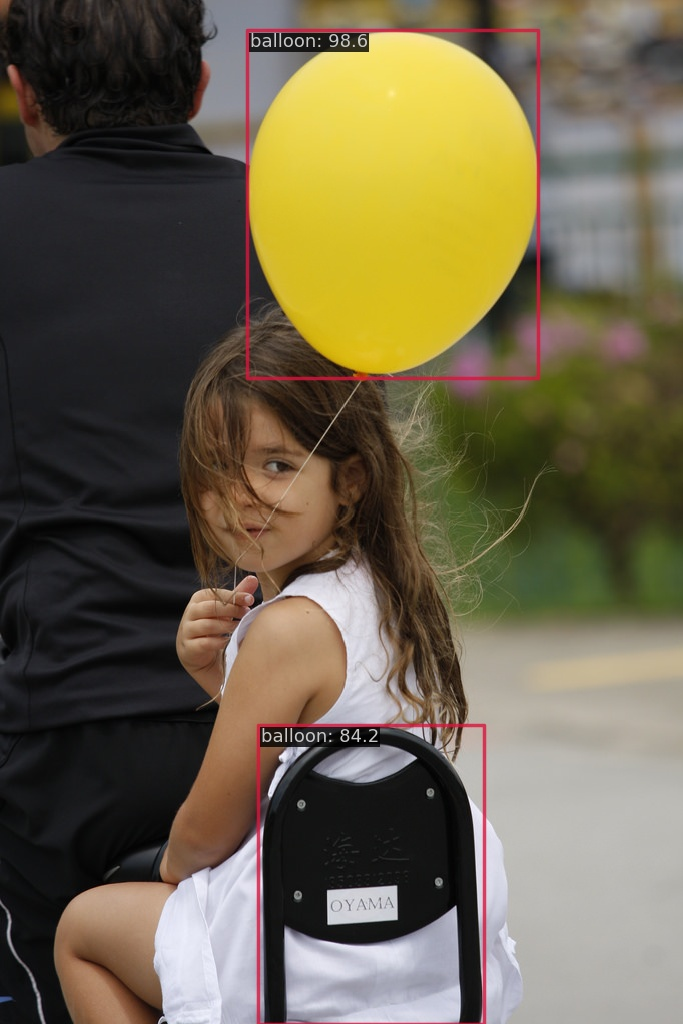

In [20]:
# Show the output image
from PIL import Image
Image.open('./output/vis/5555705118_3390d70abe_b.jpg')